**Disclosure**: Este notebooks está basado en el proceso de selección de la Consultora Fix Partners Consulting.

# Referencias
 - Diccionario prueba FIX.
 - Datos prueba Fix.
 - Prueba programación FixPartnersConsulting - Noviembre (Parte 3)

# Agenda
- Pregunta 1: Explore los datos y resuma en máximo 4 gráficos los hallazgos más importantes es su análisis exploratorio. Incluya
filtros y navegación de datos. 
- Pregunta 2: Ahora se quiere estudiar como las variables afectan 2 temas de vital importancia, la satisfacción total de los clientes y
si estos recomendarían (o no) la tienda visitada. Para cada uno de estos 2 indicadores, corra una regresión que
determine que variables son más significativas y explique cómo varían sus resultados respecto a la edad.
- Pregunta 3: Finalmente, que indicaciones (o recomendaciones) le entregarían a los gerentes de estas tiendas para ayudarlos en
su trabajo.
***

#### Carga de data set

In [78]:
#Importar Librerías
import pandas as pd
import numpy as np

# transformación
from sklearn.preprocessing import MinMaxScaler

# visualización
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', palette='inferno')

# métricas de desempeño que no están disponibles en sklearn

def RMSE(y_true,y_pred):
  from sklearn.metrics import mean_squared_error
  from math import sqrt
  return sqrt(mean_squared_error(y_true, y_pred))

def bias(y_true, y_pred):
    return sum(np.subtract(y_true, y_pred))

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [79]:
#Importar Datos
dataset = pd.read_csv('Datos prueba Fix.csv',sep = ';')
# Convertir a df
dataset = pd.DataFrame(dataset)

#### Análsisis Exploratorio de Datos

#### AED variables cualitativas nominales

In [80]:
#Creamos subset de datos de las variables cualitativas nominales que dan descripción a cada cliente.
dataset_descripcion = dataset.iloc[:, :8]
dataset_descripcion.head()

,D1,D2,D3,D4,D5,D6,D7,D8
0,1,2.0,1.0,14,2,1,3.0,3.0
1,1,2.0,1.0,7,2,3,4.0,3.0
2,1,6.0,1.0,7,2,4,1.0,2.0
3,1,5.0,1.0,7,1,3,3.0,3.0
4,1,2.0,1.0,3,2,5,3.0,1.0


In [81]:
#Corroborar Tipo Variables & Dimensiones Dataset
print('Tipo Variables\n', dataset_descripcion.dtypes)
print('Tamaño Dataset:', dataset_descripcion.shape)

#Comentario 1: Las variables de tipo float64 indican la presencia de valores nulos.

Tipo Variables
 D1      int64
D2    float64
D3    float64
D4      int64
D5      int64
D6      int64
D7    float64
D8    float64
dtype: object
Tamaño Dataset: (1998, 8)


In [82]:
#Realizamos tabla resumen para describir los datos.
dataset_descripcion.describe().round(1)

,D1,D2,D3,D4,D5,D6,D7,D8
count,1998.0,1996.0,1993.0,1998.0,1998.0,1998.0,1994.0,1991.0
mean,1.1,3.4,1.1,7.5,1.5,2.3,2.6,2.6
std,0.4,1.4,0.2,2.4,0.5,1.3,1.0,1.0
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,1.0,2.0,1.0,7.0,1.0,1.0,1.0,2.0
50%,1.0,3.0,1.0,7.0,1.0,2.0,3.0,3.0
75%,1.0,4.0,1.0,8.0,2.0,3.0,3.0,3.0
max,3.0,7.0,2.0,16.0,2.0,6.0,4.0,4.0


% Missing Values por Variable:
 D1    0.000000
D2    0.001001
D3    0.002503
D4    0.000000
D5    0.000000
D6    0.000000
D7    0.002002
D8    0.003504
dtype: float64 



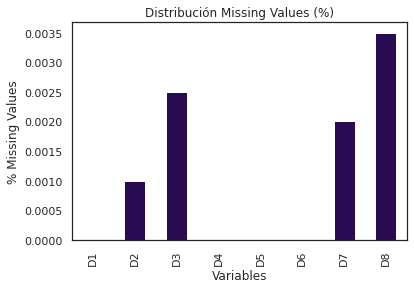

In [83]:
#Identificación Missing Values

def missing_values_distribution(df):
    print('% Missing Values por Variable:\n', df.isnull().mean(), '\n')
    df.isnull().mean().plot(kind='bar')
    plt.xlabel('Variables')
    plt.ylabel('% Missing Values')
    plt.title('Distribución Missing Values (%)')

    return plt.show()


missing_values_distribution(dataset_descripcion)

#Comentario 1: Se observa que existen Missing Values en las variables D2, D3, D7 y D8.
#Comentario 2: Se eliminaran en etapa de preprocesamiento.

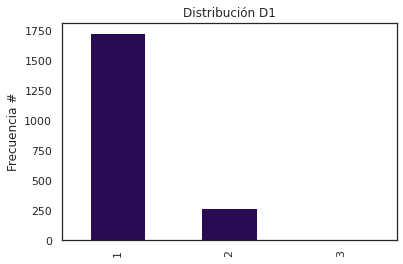

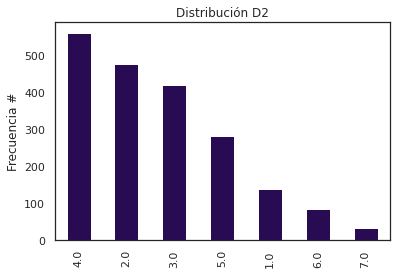

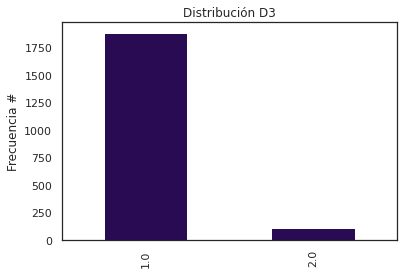

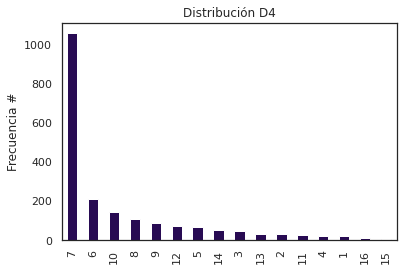

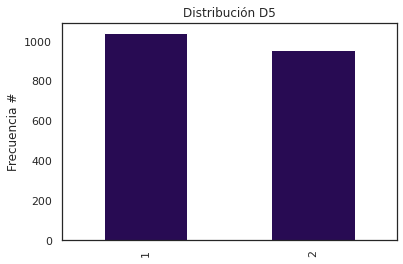

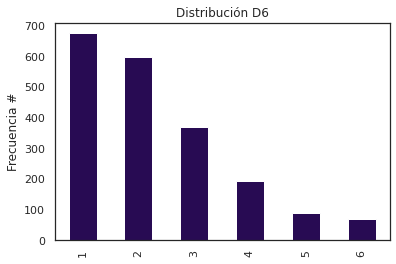

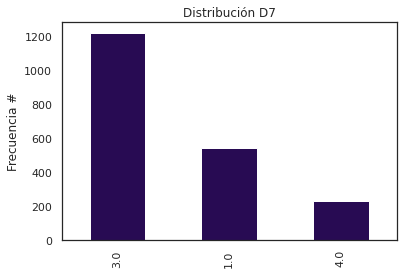

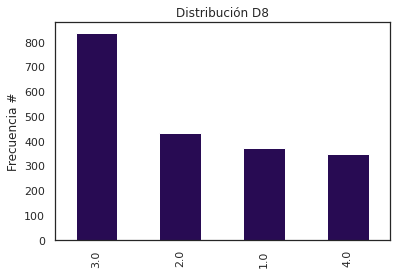

In [84]:
# Verificamos la existencia de outliers y valores incongruentes al diccionario entregado.

def barchart_variables_nominales(df, attributes):
    for i in range(0, len(attributes)):
        df[attributes[i]].value_counts().plot(kind='bar', ylabel='Frecuencia #', title=f'Distribución {attributes[i]}')
        plt.show()

    return
var_nominales = ['D1', 'D2','D3','D4','D5','D6','D7','D8']
barchart_variables_nominales(dataset, var_nominales)

#Comentario 1: No existen valores incongruentes ni outliers fuera del diccionario especificado.

#### AED variables cualitativas ordinales



In [85]:
#Creamos subset de datos de las variables cualitativas ordinales que contienen la respuestas de cada cliente en un rango de 1 a 5, donde 1 es muy en desacuerdo y 5 es muy de acuerdo.
dataset_respuestas = dataset.iloc[:, 8:]
dataset_respuestas.head()

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28
0,4.0,5,4,2.0,5,3,4.0,5,3,5,5,5.0,4,5,4.0,4,3.0,5,4.0,3,2,4.0,4.0,3.0,3,4.0,3,3
1,3.0,2,3,2.0,2,3,2.0,3,1,3,5,5.0,3,5,5.0,5,2.0,4,4.0,3,3,2.0,3.0,5.0,3,4.0,3,3
2,2.0,3,3,2.0,3,2,3.0,4,3,4,3,3.0,4,4,4.0,5,1.0,4,5.0,3,3,5.0,4.0,2.0,4,4.0,5,2
3,2.0,2,2,3.0,3,3,3.0,5,5,4,4,4.0,4,5,3.0,5,4.0,5,5.0,4,4,4.0,2.0,3.0,3,4.0,2,3
4,3.0,3,2,3.0,3,3,2.0,3,5,4,2,5.0,4,5,4.0,5,4.0,4,5.0,3,3,4.0,3.0,4.0,4,3.0,3,3


In [86]:
#Corroborar Tipo Variables & Dimensiones Dataset
print('Tipo Variables\n', dataset_respuestas.dtypes)
print('Tamaño Dataset:', dataset_respuestas.shape)

#Comentario 1: Podemos observar que hay variables de tipo Dtype = Object. Lo anterior, indica que puede existir presencia de respuestas con variables de tipo cualitativa nominal. 
#Comentario 2: Como preprocesamiento transformaremos todas las variables a números en etapa posterior.

Tipo Variables
 P1     float64
P2       int64
P3      object
P4     float64
P5      object
P6      object
P7     float64
P8      object
P9      object
P10     object
P11      int64
P12    float64
P13      int64
P14     object
P15    float64
P16      int64
P17    float64
P18      int64
P19    float64
P20      int64
P21      int64
P22    float64
P23    float64
P24    float64
P25      int64
P26    float64
P27      int64
P28      int64
dtype: object
Tamaño Dataset: (1998, 28)


In [87]:
# Describimos el dataset.
dataset_respuestas.describe().round(1)

#Comentario 1: Se puede observar que hay atributos que se consideran como variables de tipo cualitativa nominal, como: P3, P5, P6 , P7, P8, P10, P14.
#Comentario 2: Se puede observar que existen missing values en algunos atributos, los cuales no contienen 1998 registros. Ejemplo: D2 o P1.
#Comentario 3: Se puede observar que hay outliers en las respuestas de las preguntas, ya que, existen valores máximos que sobrepasan el rango cualitativo ordinal de 1 a 5, por ejemplo, en P2.

,P1,P2,P4,P7,P11,P12,P13,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28
count,1995.0,1998.0,1985.0,1995.0,1998.0,1994.0,1998.0,1983.0,1998.0,1994.0,1998.0,1996.0,1998.0,1998.0,1992.0,1994.0,1995.0,1998.0,1991.0,1998.0,1998.0
mean,2.4,7.5,2.4,2.5,4.2,4.2,6.4,3.9,4.0,3.6,4.1,29.4,3.8,23.4,3.7,3.6,3.7,3.6,3.8,3.6,3.5
std,0.5,223.7,0.5,0.5,11.1,8.9,111.8,0.9,0.9,1.0,0.7,1119.1,0.9,894.8,0.9,1.0,0.9,0.9,0.9,0.9,1.0
min,1.0,1.0,1.0,1.0,1.0,-3.0,1.0,-4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,2.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
50%,2.0,3.0,2.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0
75%,3.0,3.0,3.0,3.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
max,4.0,10000.0,3.0,4.0,500.0,400.0,5000.0,10.0,7.0,5.0,5.0,50000.0,5.0,40000.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


% Missing Values por Variable:
 P1     0.001502
P2     0.000000
P3     0.000000
P4     0.006507
P5     0.000501
P6     0.003504
P7     0.001502
P8     0.002503
P9     0.001502
P10    0.001502
P11    0.000000
P12    0.002002
P13    0.000000
P14    0.000000
P15    0.007508
P16    0.000000
P17    0.002002
P18    0.000000
P19    0.001001
P20    0.000000
P21    0.000000
P22    0.003003
P23    0.002002
P24    0.001502
P25    0.000000
P26    0.003504
P27    0.000000
P28    0.000000
dtype: float64 



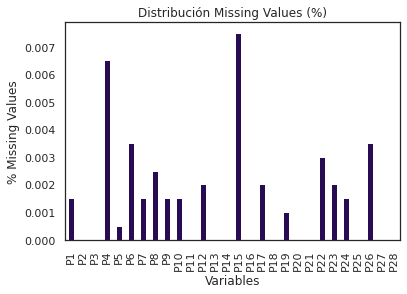

In [88]:
#Identificación Missing Values

def missing_values_distribution(df):
    print('% Missing Values por Variable:\n', df.isnull().mean(), '\n')
    df.isnull().mean().plot(kind='bar')
    plt.xlabel('Variables')
    plt.ylabel('% Missing Values')
    plt.title('Distribución Missing Values (%)')

    return plt.show()

missing_values_distribution(dataset_respuestas)

#Comentario 1: Se observa que existen Missing Values en 16 atributos. Se eliminaran en etapa posterior.

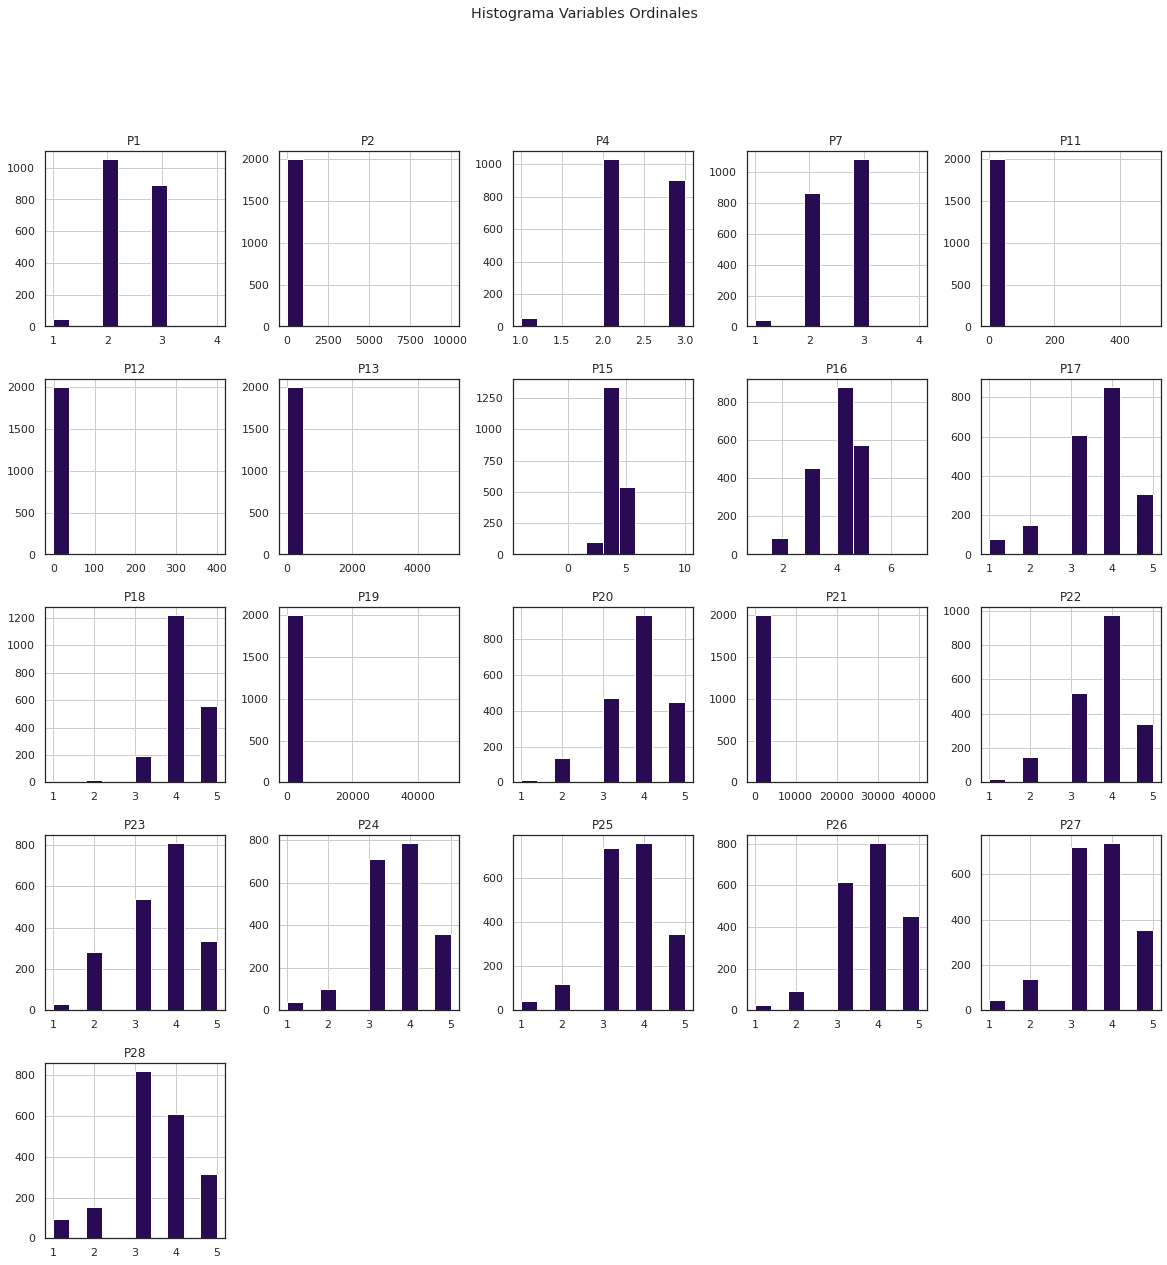

In [89]:
# Verificamos la existencia de outliers y valores incongruentes al diccionario entregado.


def histograma_variables_numericas(df, bins):
    df.hist(bins=bins, figsize=(20, 20))
    plt.suptitle('Histograma Variables Ordinales')

    return plt.show()

histograma_variables_numericas(dataset_respuestas, bins=10)

#Comentario 1: Encontramos outliers en algunas preguntas (P2, P11, P12, P13, P15, P16, P19, P21).
#Comentario 2: Se eliminaran en etapa de preprocesamiento.


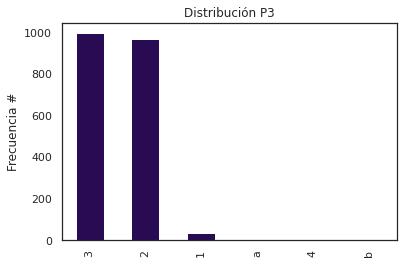

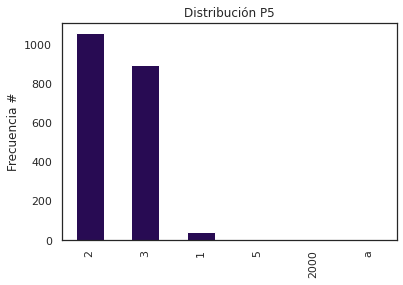

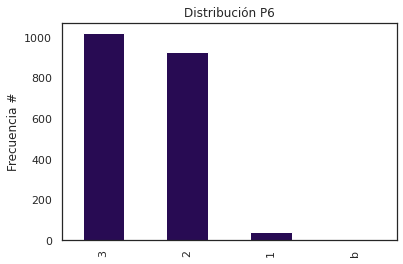

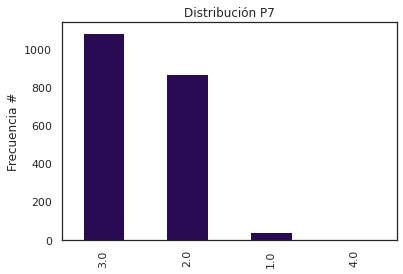

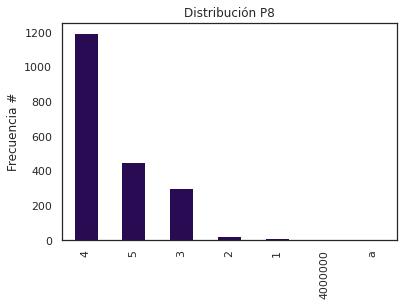

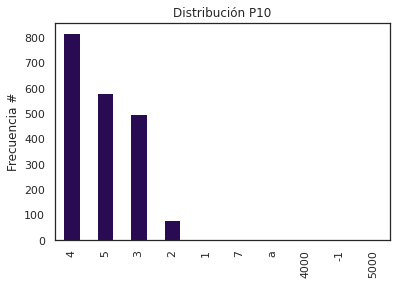

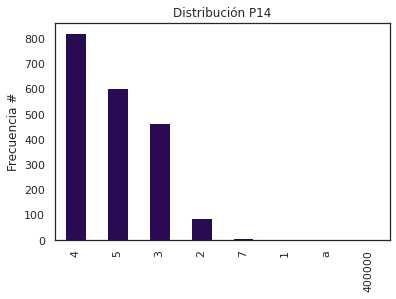

In [90]:
# Verificaremos por que los atributos P3, P5, P6 , P7, P8, P10, P14 se consideran Dtype = object.

def barchart_variables_nominales(df, attributes):
    for i in range(0, len(attributes)):
        df[attributes[i]].value_counts().plot(kind='bar', ylabel='Frecuencia #', title=f'Distribución {attributes[i]}')
        plt.show()

    return

var_nominales = ['P3', 'P5','P6','P7','P8','P10', 'P14']
barchart_variables_nominales(dataset_respuestas, var_nominales)

#Comentario 1: Podemos concluir que los atributos P3, P5, P6 , P7, P8, P10, P14 se consideran de como Dtype = object, puesto que, contienen en sus respuestas variables de tipo categóricas nominales como: b, a.
#Comentario 2: Podemos concluir que en estos atributos tambien existen outliers, fuera del rango de las variables cualitativas ordinales de 1 a 5, como : -1, 2000, 4000000.
#Comentario 3: Se reemplazaran por valores nulos todos las variables outliers.

#### Preprocesamiento y limpieza

In [91]:
#Convertimos todas las variables a formato númerico, en el caso que encuentre otro tipo de variable lo reemplazamos por nulo.

dataset_respuestas_clean = dataset.apply(pd.to_numeric, errors='coerce', downcast='integer')
dataset_respuestas_clean
print('Tipo Variables\n', dataset_respuestas_clean.dtypes)
print('Tamaño Dataset:', dataset_respuestas_clean.shape)

#Comentario 1: Todas las variables de los atributos de respuestas quedan como números. Para el caso de los atributos donde existan valores nulos estos quedan como float.

Tipo Variables
 D1        int8
D2     float64
D3     float64
D4        int8
D5        int8
D6        int8
D7     float64
D8     float64
P1     float64
P2       int16
P3     float64
P4     float64
P5     float64
P6     float64
P7     float64
P8     float64
P9     float64
P10    float64
P11      int16
P12    float64
P13      int16
P14    float64
P15    float64
P16       int8
P17    float64
P18       int8
P19    float64
P20       int8
P21      int32
P22    float64
P23    float64
P24    float64
P25       int8
P26    float64
P27       int8
P28       int8
dtype: object
Tamaño Dataset: (1998, 36)


In [92]:
# Declaramos valores inconsistentes en cada columna, segun AED.

dataset_respuestas_clean.loc[dataset_respuestas_clean['P2'] < 1, 'P2'] = np.nan
dataset_respuestas_clean.loc[dataset_respuestas_clean['P2'] > 5, 'P2'] = np.nan
dataset_respuestas_clean.loc[dataset_respuestas_clean['P5'] < 1, 'P5'] = np.nan
dataset_respuestas_clean.loc[dataset_respuestas_clean['P5'] > 5, 'P5'] = np.nan
dataset_respuestas_clean.loc[dataset_respuestas_clean['P8'] < 1, 'P8'] = np.nan
dataset_respuestas_clean.loc[dataset_respuestas_clean['P8'] > 5, 'P8'] = np.nan
dataset_respuestas_clean.loc[dataset_respuestas_clean['P10'] < 1, 'P10'] = np.nan
dataset_respuestas_clean.loc[dataset_respuestas_clean['P10'] > 5, 'P10'] = np.nan
dataset_respuestas_clean.loc[dataset_respuestas_clean['P11'] < 1, 'P11'] = np.nan
dataset_respuestas_clean.loc[dataset_respuestas_clean['P11'] > 5, 'P11'] = np.nan
dataset_respuestas_clean.loc[dataset_respuestas_clean['P12'] < 1, 'P12'] = np.nan
dataset_respuestas_clean.loc[dataset_respuestas_clean['P12'] > 5, 'P12'] = np.nan
dataset_respuestas_clean.loc[dataset_respuestas_clean['P13'] < 1, 'P13'] = np.nan
dataset_respuestas_clean.loc[dataset_respuestas_clean['P13'] > 5, 'P13'] = np.nan
dataset_respuestas_clean.loc[dataset_respuestas_clean['P14'] < 1, 'P14'] = np.nan
dataset_respuestas_clean.loc[dataset_respuestas_clean['P14'] > 5, 'P14'] = np.nan
dataset_respuestas_clean.loc[dataset_respuestas_clean['P15'] < 1, 'P15'] = np.nan
dataset_respuestas_clean.loc[dataset_respuestas_clean['P15'] > 5, 'P15'] = np.nan
dataset_respuestas_clean.loc[dataset_respuestas_clean['P16'] < 1, 'P16'] = np.nan
dataset_respuestas_clean.loc[dataset_respuestas_clean['P16'] > 5, 'P16'] = np.nan
dataset_respuestas_clean.loc[dataset_respuestas_clean['P19'] < 1, 'P19'] = np.nan
dataset_respuestas_clean.loc[dataset_respuestas_clean['P19'] > 5, 'P19'] = np.nan
dataset_respuestas_clean.loc[dataset_respuestas_clean['P21'] < 1, 'P21'] = np.nan
dataset_respuestas_clean.loc[dataset_respuestas_clean['P21'] > 5, 'P21'] = np.nan

In [93]:
#Eliminamos missing values 
dataset_respuestas_clean = dataset_respuestas_clean.dropna()
dataset_respuestas_clean.isna().sum()

D1     0
D2     0
D3     0
D4     0
D5     0
D6     0
D7     0
D8     0
P1     0
P2     0
P3     0
P4     0
P5     0
P6     0
P7     0
P8     0
P9     0
P10    0
P11    0
P12    0
P13    0
P14    0
P15    0
P16    0
P17    0
P18    0
P19    0
P20    0
P21    0
P22    0
P23    0
P24    0
P25    0
P26    0
P27    0
P28    0
dtype: int64

In [94]:
#Corroborar Tipo Variables & Dimensiones Dataset
print('Tipo Variables\n', dataset_respuestas_clean.dtypes)
print('Tamaño Dataset:', dataset_respuestas_clean.shape)

Tipo Variables
 D1        int8
D2     float64
D3     float64
D4        int8
D5        int8
D6        int8
D7     float64
D8     float64
P1     float64
P2     float64
P3     float64
P4     float64
P5     float64
P6     float64
P7     float64
P8     float64
P9     float64
P10    float64
P11    float64
P12    float64
P13    float64
P14    float64
P15    float64
P16    float64
P17    float64
P18       int8
P19    float64
P20       int8
P21    float64
P22    float64
P23    float64
P24    float64
P25       int8
P26    float64
P27       int8
P28       int8
dtype: object
Tamaño Dataset: (1835, 36)


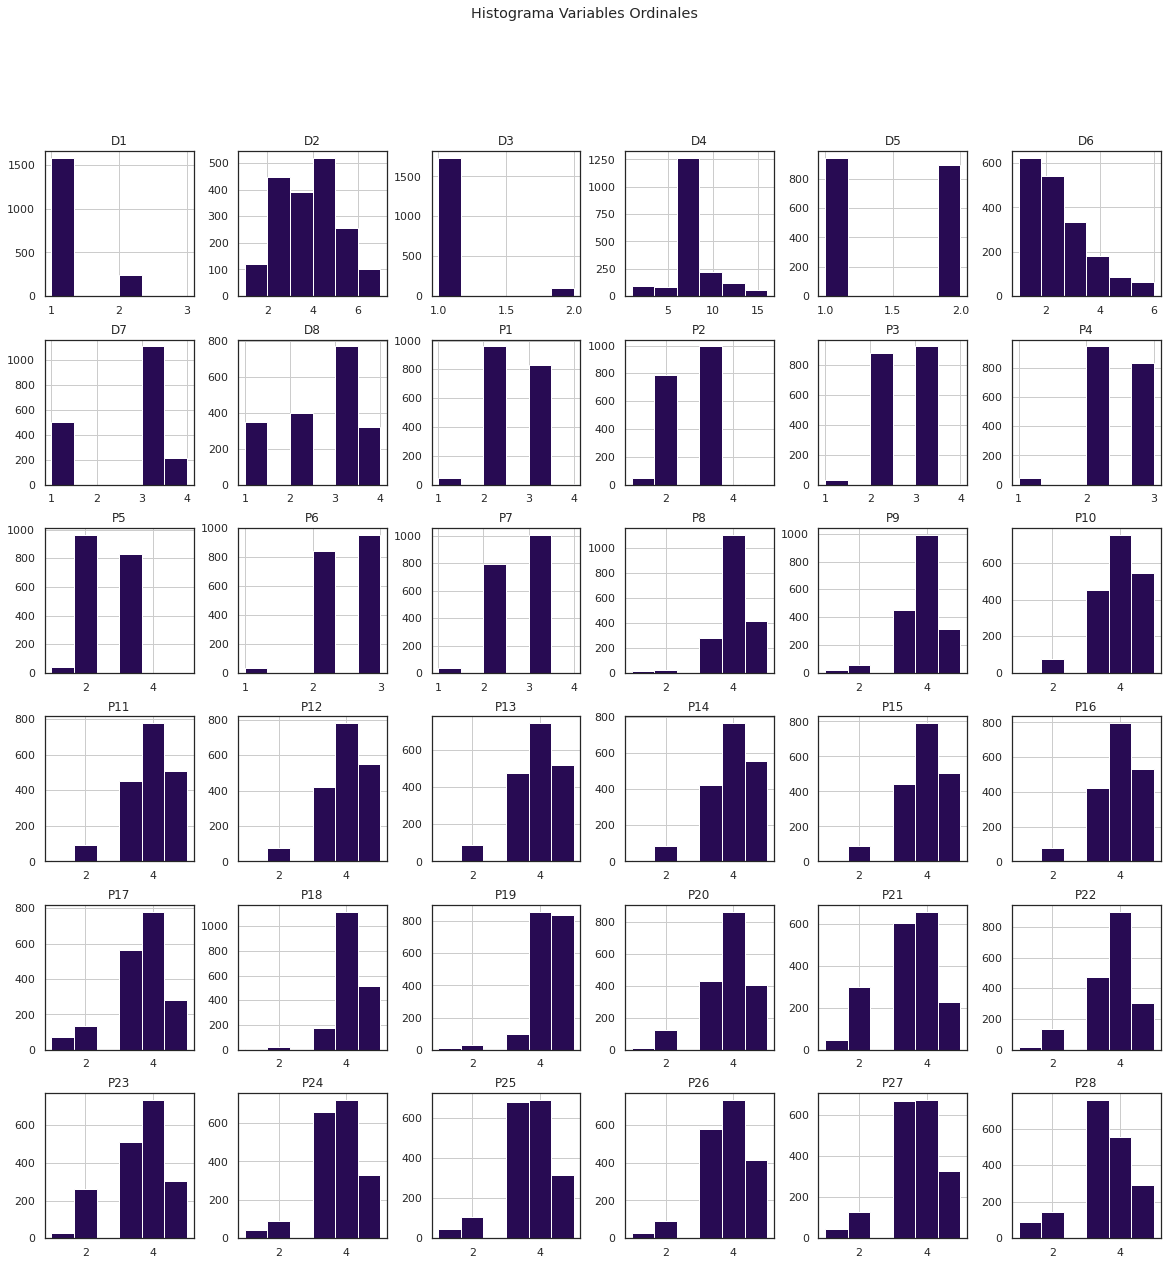

In [95]:
# Verificamos la existencia de outliers y valores incongruentes al diccionario entregado.


def histograma_variables_numericas(df, bins):
    df.hist(bins=bins, figsize=(20, 20))
    plt.suptitle('Histograma Variables Ordinales')

    return plt.show()

histograma_variables_numericas(dataset_respuestas_clean, bins=6)



#### Modelado

Se utilizarán como etiquetas las preguntas P18: Satisfacción de evaluación y  P19: Recomendación de la evaluación. Estas variables se transformaran en variables dummy del tipo 1 = {Neutral, De acuerdo, Muy de acuerdo} y 0 = {Muy en desacuerdo, En desacuerdo}

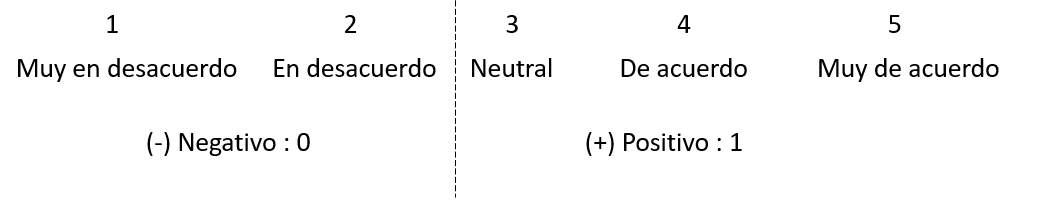

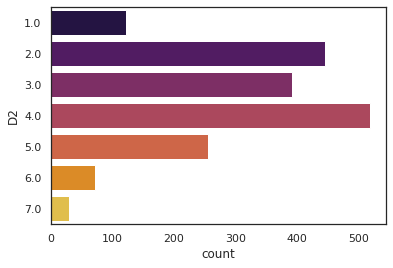

In [49]:
#Grupos por edad
sns.countplot(y='D2', data=dataset_respuestas_clean, palette='inferno')

#Comentario 1: La encuesta se concentra en los grupos de edad 2 : 25-34	, 3 : 35-44	 , 4 : 45-54	

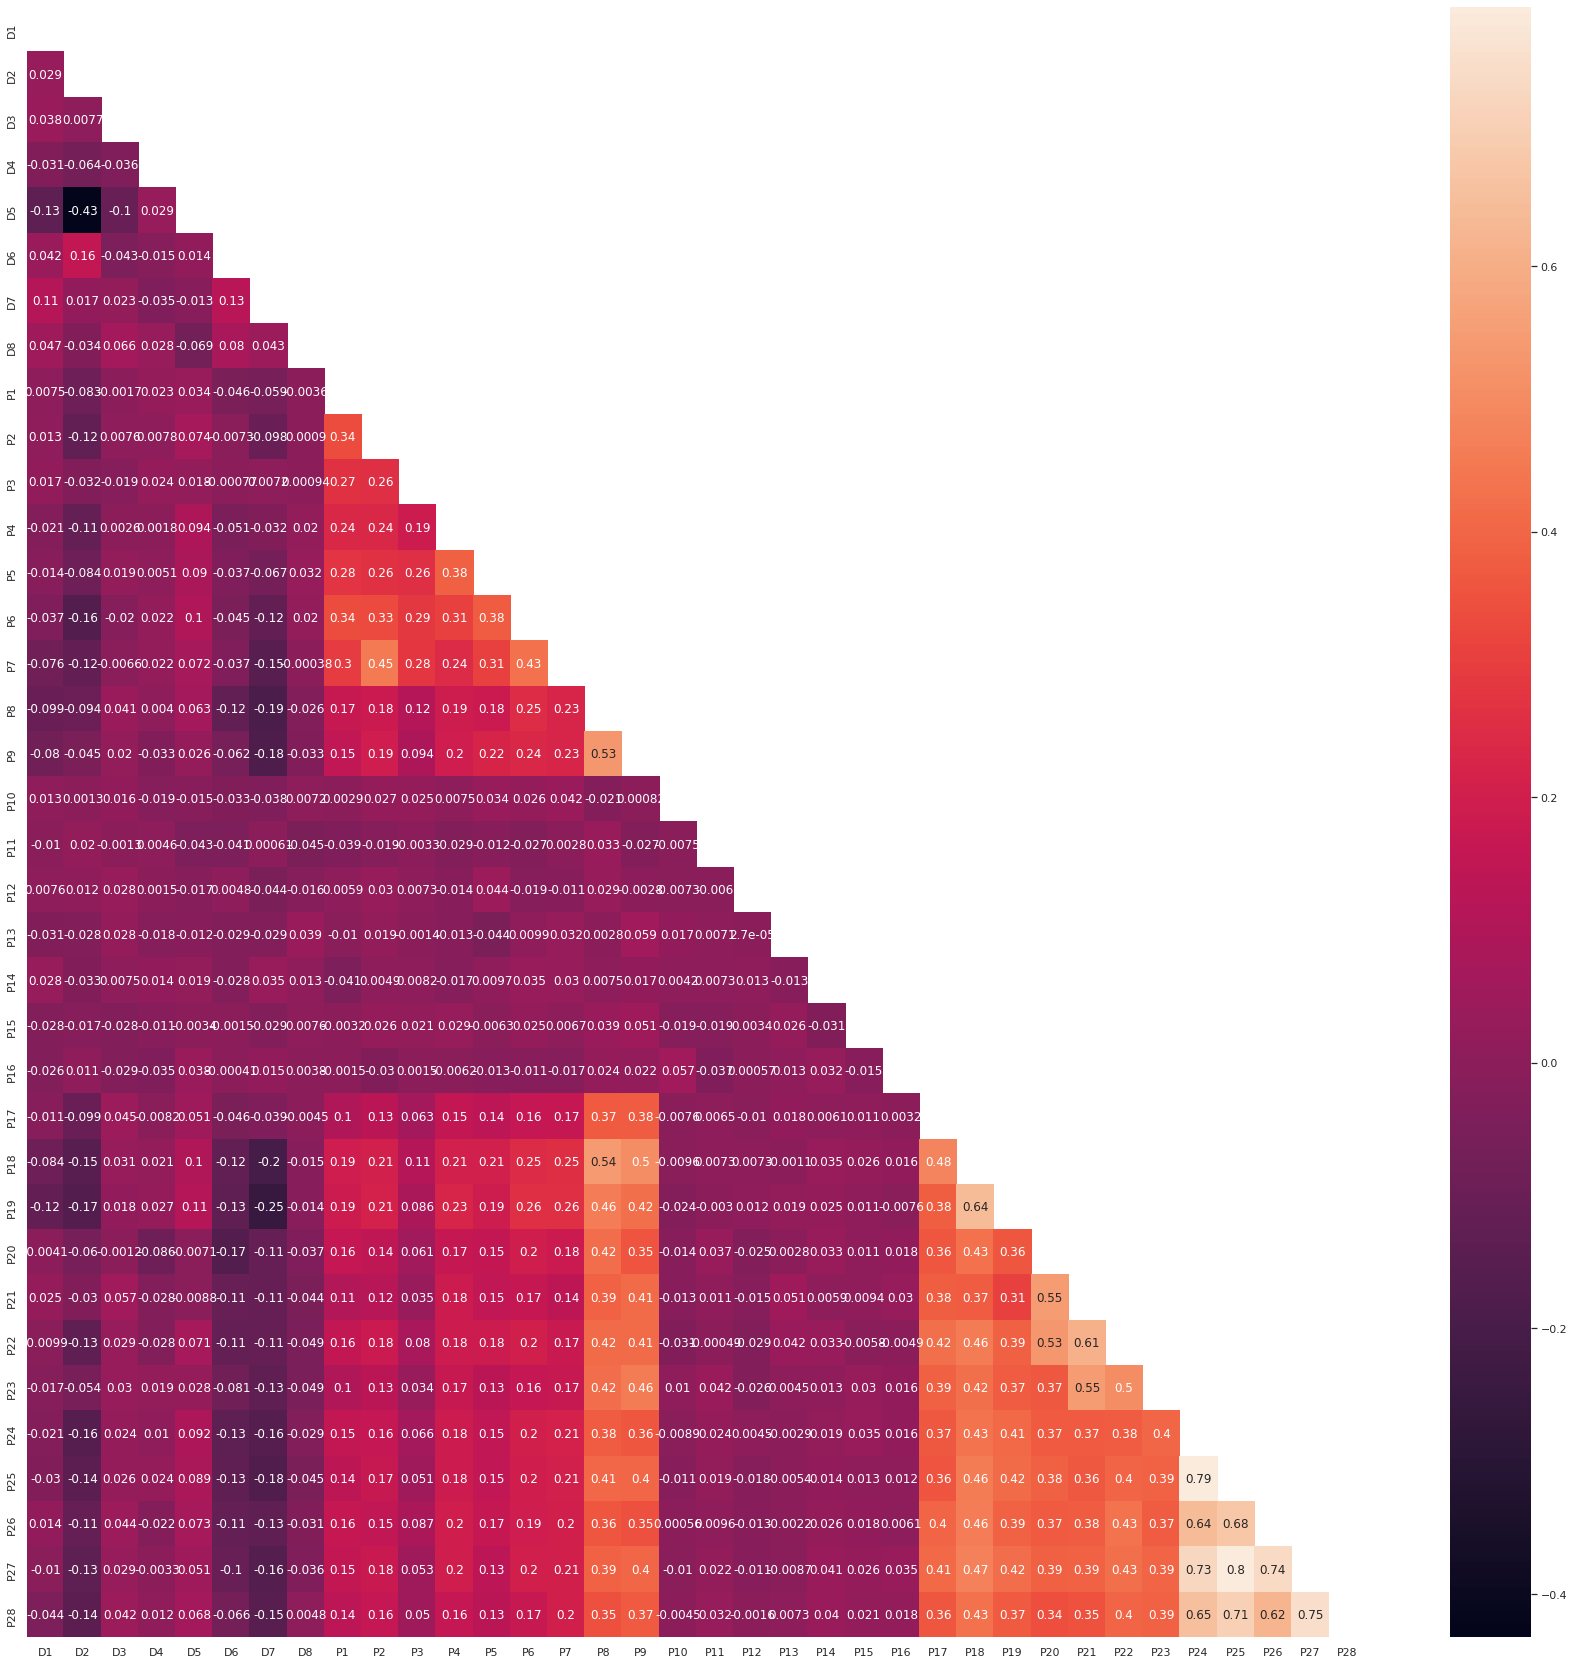

In [103]:
plt.figure(figsize=(30,30))
# computamos la matriz de correlación
corr_matrix = dataset_respuestas_clean.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# plot
sns.heatmap(corr_matrix,mask=mask,annot=True)

In [104]:
# "Satisfacción total de clientes".

#Transformacion 
dataset_final_1 = dataset_respuestas_clean.copy()

#Eliminamos variables manualmente

dataset_final_1.drop('P18', axis=1, inplace=True)
dataset_final_1.drop('D1', axis=1, inplace=True)
dataset_final_1.drop('D3', axis=1, inplace=True)
dataset_final_1.drop('D4', axis=1, inplace=True)
dataset_final_1.drop('D5', axis=1, inplace=True)
dataset_final_1.drop('D6', axis=1, inplace=True)
dataset_final_1.drop('D7', axis=1, inplace=True)
dataset_final_1.drop('D8', axis=1, inplace=True)

dataset_final_1.head()
dataset_final_1.describe()

,D2,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28
count,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000
mean,3.365123,2.431063,2.516621,2.488283,2.431063,2.433787,2.500272,2.529155,4.028338,3.827793,3.952589,3.917166,3.979837,3.919891,3.973297,3.931335,3.966213,3.578747,4.346049,3.829428,3.391826,3.732425,3.558038,3.658311,3.612534,3.767847,3.605995,3.446866
std,1.348566,0.541631,0.553685,0.532733,0.544643,0.539955,0.538967,0.539189,0.703057,0.785495,0.862674,0.865367,0.845881,0.871587,0.862932,0.852013,0.847700,0.967681,0.723216,0.874207,0.982196,0.857204,0.974755,0.903393,0.918581,0.902288,0.934068,1.003149
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,3.000000,2.000000,3.000000,3.000000,2.000000,2.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000
75%,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,7.000000,4.000000,5.000000,4.000000,3.000000,5.000000,3.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [105]:
from sklearn.model_selection import train_test_split
# split
X_train, X_test, y_train, y_test = train_test_split(dataset_final_1[dataset_final_1.columns.difference(['P19'])], dataset_final_1['P19'], test_size=0.2, random_state=101)

# train
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression().fit(X_train, y_train)
pd.DataFrame({"Feature":X_test.columns.tolist(),"Coefficients":linear_reg.coef_.tolist()})

,Feature,Coefficients
0,D2,-0.042216
1,P1,0.038592
2,P10,-0.022998
3,P11,-0.015397
4,P12,0.015144
5,P13,0.009815
6,P14,0.002725
7,P15,-0.010087
8,P16,-0.012892
9,P17,0.078412


In [106]:
# "Recomendación de la tienda".

dataset_final_2 = dataset_respuestas_clean.copy()

#Eliminamos variables manualmente

dataset_final_2.drop('P19', axis=1, inplace=True)
dataset_final_2.drop('D1', axis=1, inplace=True)
dataset_final_2.drop('D3', axis=1, inplace=True)
dataset_final_2.drop('D4', axis=1, inplace=True)
dataset_final_2.drop('D5', axis=1, inplace=True)
dataset_final_2.drop('D6', axis=1, inplace=True)
dataset_final_2.drop('D7', axis=1, inplace=True)
dataset_final_2.drop('D8', axis=1, inplace=True)

dataset_final_2.head()
dataset_final_2.describe()

,D2,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P20,P21,P22,P23,P24,P25,P26,P27,P28
count,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000
mean,3.365123,2.431063,2.516621,2.488283,2.431063,2.433787,2.500272,2.529155,4.028338,3.827793,3.952589,3.917166,3.979837,3.919891,3.973297,3.931335,3.966213,3.578747,4.148774,3.829428,3.391826,3.732425,3.558038,3.658311,3.612534,3.767847,3.605995,3.446866
std,1.348566,0.541631,0.553685,0.532733,0.544643,0.539955,0.538967,0.539189,0.703057,0.785495,0.862674,0.865367,0.845881,0.871587,0.862932,0.852013,0.847700,0.967681,0.660617,0.874207,0.982196,0.857204,0.974755,0.903393,0.918581,0.902288,0.934068,1.003149
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,3.000000,2.000000,3.000000,3.000000,2.000000,2.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000
75%,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,7.000000,4.000000,5.000000,4.000000,3.000000,5.000000,3.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [107]:
from sklearn.model_selection import train_test_split
# split
X_train, X_test, y_train, y_test = train_test_split(dataset_final_2[dataset_final_2.columns.difference(['P18'])], dataset_final_2['P18'], test_size=0.2, random_state=101)

# train
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression().fit(X_train, y_train)
pd.DataFrame({"Feature":X_test.columns.tolist(),"Coefficients":linear_reg.coef_.tolist()})

,Feature,Coefficients
0,D2,-0.028690
1,P1,0.033484
2,P10,-0.002864
3,P11,-0.008365
4,P12,0.000201
5,P13,-0.013536
6,P14,0.005668
7,P15,0.004588
8,P16,0.002608
9,P17,0.127293
